In [13]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

In [14]:
def hourly_return(df):
    c = df.close
    return (c - c.shift(1)) / c

In [15]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [16]:
def max_drawdown(df):
    c = df.close
    cummax = df.high.cummax()
    drawdowns = (c - cummax) / cummax
    return drawdowns.cummin()

In [17]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [18]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'
events_db = 'crypto_events_database'

In [19]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [20]:
prices['hrly_return'] = hourly_return(prices)
prices['volatility'] = vol_ohlc(prices)
prices['mdd'] = max_drawdown(prices)

In [21]:
prices.tail()

,open,high,low,close,volume,volumeUSD,token,chain,hrly_return,volatility,mdd
ts,,,,,,,,,,,
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC,-0.012652,0.127073,-0.037067
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC,-0.017123,0.138592,-0.037067
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC,-0.012242,0.167518,-0.045870
2021-11-10 22:00:00,65835.00,66165.64,62800.00,64299.57,2769.796161,1.792954e+08,BTC,BTC,-0.023879,0.245725,-0.068122
2021-11-10 23:00:00,64292.43,65325.32,63913.63,65159.85,966.112116,6.250044e+07,BTC,BTC,0.013203,0.251504,-0.068122


In [22]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

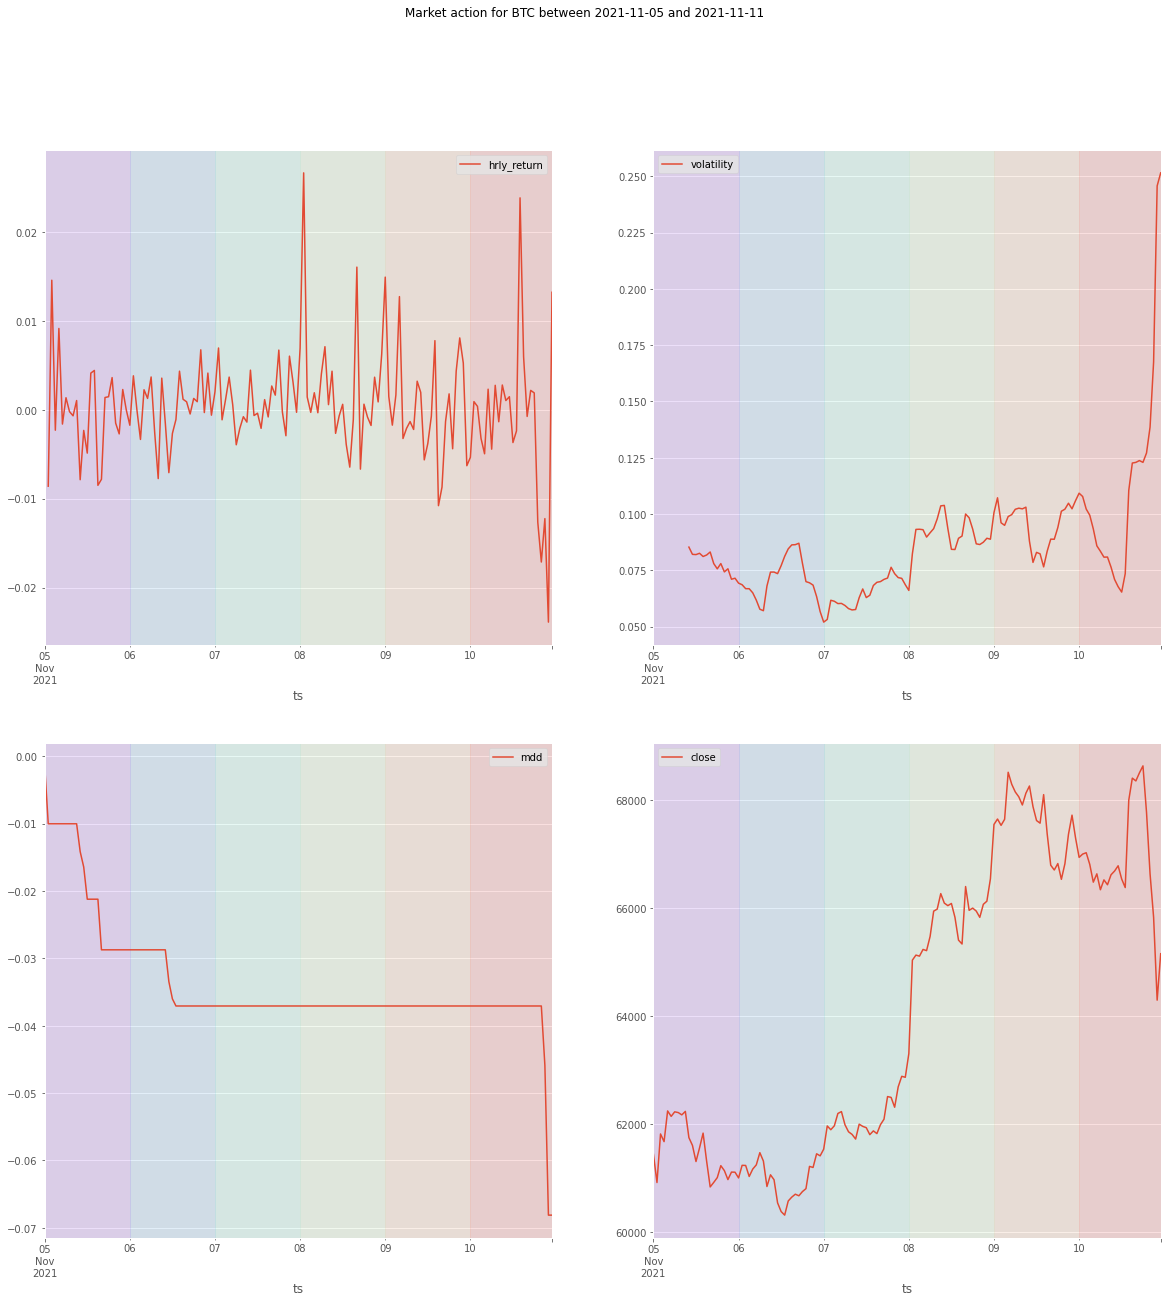

In [23]:
series_plot(prices[['hrly_return']], None, ax=ax[0, 0])
series_plot(prices[['volatility']], None, ax=ax[0, 1])
series_plot(prices[['mdd']], None, ax=ax[1, 0])
series_plot(prices[['close']], None, ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

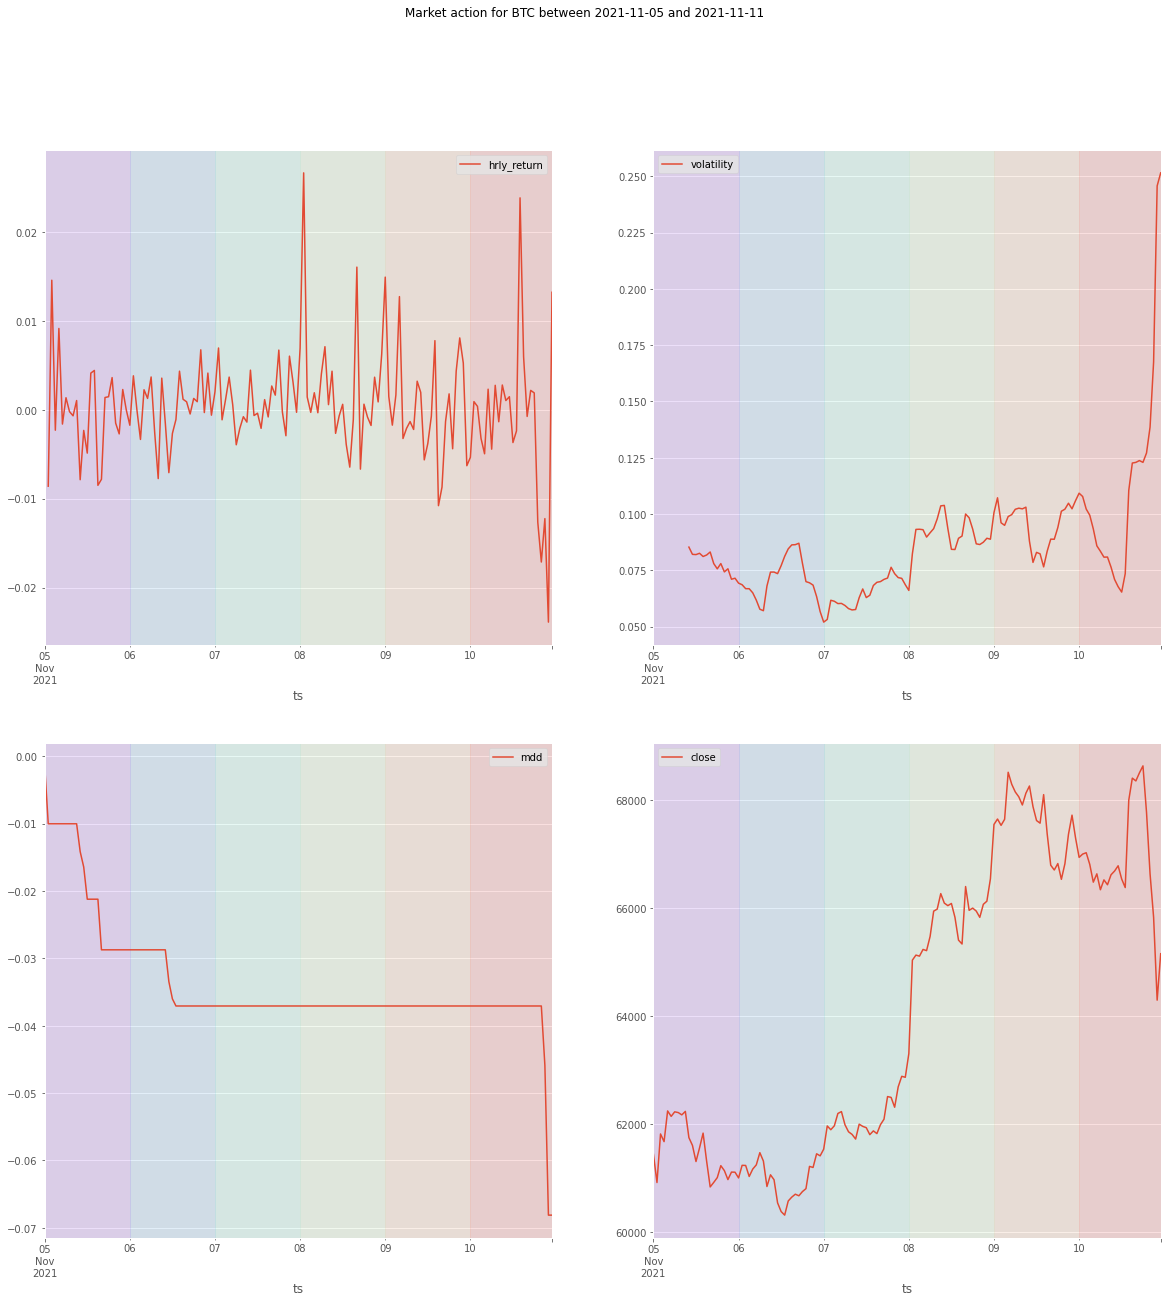

In [24]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)